# Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import os
import glob
import matplotlib.pyplot as plt
import math
import cv2


%matplotlib inline

In [2]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Importing Data

In [3]:
data_nail = pd.read_excel("merged_data.xlsx", sheet_name="nail")
data_tongue = pd.read_excel("merged_data.xlsx", sheet_name="tongue")
data_palm = pd.read_excel("merged_data.xlsx", sheet_name="palm")
common_ids = pd.read_excel("merged_data.xlsx", sheet_name="common_ids")

In [4]:
train, test = train_test_split(common_ids, test_size=0.3)
train, test = train["number"].tolist(), test["number"].tolist()

In [5]:
nail_train, nail_test = data_nail[data_nail['number'].isin(train)], data_nail[data_nail['number'].isin(test)]
tongue_train, tongue_test = data_tongue[data_tongue['number'].isin(train)], data_tongue[data_tongue['number'].isin(test)]
palm_train, palm_test = data_palm[data_palm['number'].isin(train)], data_palm[data_palm['number'].isin(test)]

## Nail

In [6]:
X_nail_train = nail_train.drop(columns=['number','label']).to_numpy()
X_nail_test = nail_test.drop(columns=['number','label']).to_numpy()

## Tongue

In [7]:
X_tongue_train = tongue_train.drop(columns=['number','label']).to_numpy()
X_tongue_test = tongue_test.drop(columns=['number','label']).to_numpy()

## Palm

In [8]:
X_palm_train = palm_train.drop(columns=['number','label']).to_numpy()
X_palm_test = palm_test.drop(columns=['number','label']).to_numpy()

## Labels

In [9]:
y_train = nail_train['label'].to_numpy()
y_test = nail_test['label'].to_numpy()

# Preprocessing

In [10]:
scaler = MinMaxScaler(copy=False)
# scaler = StandardScaler(copy=False)

In [11]:
X_nail_train = scaler.fit_transform(X_nail_train)
X_nail_test = scaler.fit_transform(X_nail_test)

In [12]:
X_tongue_train = scaler.fit_transform(X_tongue_train)
X_tongue_test = scaler.fit_transform(X_tongue_test)

In [13]:
X_palm_train = scaler.fit_transform(X_palm_train)
X_palm_test = scaler.fit_transform(X_palm_test)

# Helper Functions

In [14]:
def predict(X,beta,b):
    return np.dot(X,beta) + b

In [15]:
def loss(y_true,y_hat,y_pred,coeff,mse):
    
    y_nail, y_tongue, y_palm = y_pred
    a, b, c = coeff
    mse_nail, mse_tongue, mse_palm = mse

    cost = mean_squared_error(y_true, y_hat) + a*mse_nail + b*mse_tongue + c*mse_palm

    return cost

In [16]:
def gradients(y_true,y_hat,weights,coeff,X,intercept):

    weights_nail, weights_tongue, weights_palm = weights
    b_nail, b_tongue, b_palm = intercept
    X_nail, X_tongue, X_palm = X
    a, b, c = coeff
    
    y_pred_nail = predict(X_nail_train, beta_nail, b_nail)
    y_pred_tongue = predict(X_tongue_train, beta_tongue, b_tongue)
    y_pred_palm = predict(X_palm_train, beta_palm, b_palm)

    N = X_nail.shape[0]

    dw_nail = (-2*a)*np.dot(X_nail.T,2*y_true-y_hat-y_pred_nail)/N
    dw_tongue = (-2*b)*np.dot(X_tongue.T,2*y_true-y_hat-y_pred_tongue)/N
    dw_palm = (-2*c)*np.dot(X_palm.T,2*y_true-y_hat-y_pred_palm)/N

    db_nail = (-2*a/N)*np.sum(2*y_true-y_hat-y_pred_nail)
    db_tongue = (-2*b/N)*np.sum(2*y_true-y_hat-y_pred_tongue)
    db_palm = (-2*c/N)*np.sum(2*y_true-y_hat-y_pred_palm)

    da = (np.dot(y_true,y_true) - 4*np.dot(y_true,y_pred_nail) + np.dot(y_pred_nail,y_pred_nail) - np.dot(y_hat,y_pred_nail))/N
    db = (np.dot(y_true,y_true) - 4*np.dot(y_true,y_pred_tongue) + np.dot(y_pred_tongue,y_pred_tongue) - np.dot(y_hat,y_pred_tongue))/N
    dc = (np.dot(y_true,y_true) - 4*np.dot(y_true,y_pred_palm) + np.dot(y_pred_palm,y_pred_palm) - np.dot(y_hat,y_pred_palm))/N
    # db = da = 0

    return [dw_nail, dw_tongue, dw_palm, db_nail, db_tongue, db_palm, da, db, dc]

In [17]:
def sq_sum(a,b,c):
    return math.sqrt(a**2 + b**2 + c**2)

# Driver Code

## Initilisation 

In [64]:
a, b, c = 1.0, 1.0, 1.0

features = X_nail_train.shape[1]
rows = X_nail_train.shape[0]

beta_nail = np.array([1.0]*features)
b_nail = 1.0

beta_tongue = np.array([1.0]*features)
b_tongue = 1.0

beta_palm = np.array([1.0]*features)
b_palm = 1.0

train_loss = []
mse_nail_loss = []
mse_tongue_loss = []
mse_palm_loss = []

alpha = 0.1
iterations = 1050

print(f"Shape of training data is {X_nail_train.shape}")

Shape of training data is (182, 14)


## Training

Training Complete


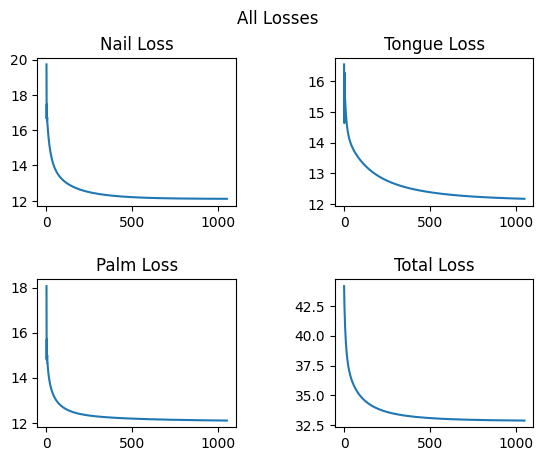

In [65]:
for i in range(iterations):

    # print(f"-----------------------------------------------------------------------------------------")
    # print(f"Iteration {i+1}")

    
    # PREDICTION
    y_pred_nail = predict(X_nail_train, beta_nail, b_nail)
    y_pred_tongue = predict(X_tongue_train, beta_tongue, b_tongue)
    y_pred_palm = predict(X_palm_train, beta_palm, b_palm)

    # print(f"actual prediction = {y_train}")    
    # print(f"beta coeff of nail = {beta_nail}")
    # print(f"prediction of tongue = {y_pred_tongue}")
    # print(f"prediction of palm = {y_pred_palm}")

    
    # MEAN SQUARED ERROR
    mse_nail = mean_squared_error(y_train, y_pred_nail)
    mse_tongue = mean_squared_error(y_train, y_pred_tongue)
    mse_palm = mean_squared_error(y_train, y_pred_palm)
    
    mse_nail_loss.append(mse_nail)
    mse_tongue_loss.append(mse_tongue)
    mse_palm_loss.append(mse_palm)

  
    # print(f"mse of nail = {mse_nail}")
    # print(f"mse of tongue = {mse_tongue}")
    # print(f"mse of palm = {mse_palm}")

    
    # SUM OF SQUARES OF COEFF = 1
    denom = sq_sum(a,b,c)
    a, b, c = a/denom, b/denom, c/denom

    
    # FINAL PREDICTION
    y_hat = a*y_pred_nail + b*y_pred_tongue + c*y_pred_palm
    # print(f"prediction = {y_hat}")
    # print(f"mse overall = {mean_squared_error(y_train, y_hat)}")

    
    # LOSS FUNCTION ATTRIBUTES
    y_pred = [y_pred_nail, y_pred_tongue, y_pred_palm]
    coeff = [a, b, c]
    weights = [beta_nail, beta_tongue, beta_palm]
    mse = [mse_nail, mse_tongue, mse_palm]
    X = [X_nail_train, X_tongue_train, X_palm_train]
    intercept = [b_nail, b_tongue, b_palm]

    
    # LOSS FUNCTION
    train_loss.append(loss(y_train,y_hat,y_pred,coeff,mse))
    
    
    # GRADIENTS
    dw = gradients(y_train,y_hat,weights,coeff,X,intercept)
    dw_nail, dw_tongue, dw_palm, db_nail, db_tongue, db_palm, da, db, dc = dw

    
    # UPDATING PARAMETERS
    beta_nail -= alpha*dw_nail
    beta_tongue -= alpha*dw_tongue
    beta_palm -= alpha*dw_palm
    
    b_nail -= alpha*db_nail
    b_tongue -= alpha*db_tongue
    b_palm -= alpha*db_palm
    
    a -= alpha*da 
    b -= alpha*db 
    c -= alpha*dc

    # SUM OF SQUARES OF COEFF = 1
    denom = sq_sum(a,b,c)
    a, b, c = a/denom, b/denom, c/denom

print("Training Complete")

# Plotting Nail Loss
plt.subplot(2,2,1)
plt.plot(mse_nail_loss)
plt.title("Nail Loss")

# Plotting Tongue Loss
plt.subplot(2,2,2)
plt.plot(mse_tongue_loss)
plt.title("Tongue Loss")

# Plotting Palm Loss
plt.subplot(2,2,3)
plt.plot(mse_palm_loss)
plt.title("Palm Loss")

# Plotting Total Loss
plt.subplot(2,2,4)
plt.plot(train_loss)
plt.title("Total Loss")

plt.suptitle("All Losses")
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

In [84]:
print(f"Standard Deviation in last 50 values of training loss is {np.std(np.array(train_loss[-50:]))}")

Standard Deviation in last 50 values of training loss is 0.0017261762139721517


In [85]:
print(f"Standard Deviation in last 50 values of nail loss is {np.std(np.array(mse_nail_loss[-50:]))}")

Standard Deviation in last 50 values of nail loss is 0.0004203532159572914


In [86]:
print(f"Standard Deviation in last 50 values of tongue loss is {np.std(np.array(mse_tongue_loss[-50:]))}")

Standard Deviation in last 50 values of tongue loss is 0.002415625361027086


In [87]:
print(f"Standard Deviation in last 50 values of palm loss is {np.std(np.array(mse_palm_loss[-50:]))}")

Standard Deviation in last 50 values of palm loss is 0.00117036184979713


In [88]:
print(f"coeff of nail = {a}")
print(f"coeff of tongue = {b}")
print(f"coeff of palm = {c}")

coeff of nail = 0.5775488437138706
coeff of tongue = 0.5768242243489099
coeff of palm = 0.5776773730457595


In [89]:
print(f"beta coeff of nail = {beta_nail}")    
print(f"-----------------------------------------------------------------------------------------")
print(f"beta coeff of tongue = {beta_tongue}")
print(f"-----------------------------------------------------------------------------------------")
print(f"beta coeff of palm = {beta_palm}")

beta coeff of nail = [-0.74777303 -0.54639231  2.83604961  2.7003142   0.26098981 -0.24684046
 -0.67883711  0.00345825 -0.42220764  0.29748152  0.1527054  -0.67883711
 -1.12053637 -1.30014475]
-----------------------------------------------------------------------------------------
beta coeff of tongue = [-0.21968754  0.24024317  0.95438587  0.41419396  1.41448401  0.627611
 -0.41502156 -0.80552701 -0.41264519  0.58948119 -2.07431983 -0.41502156
 -1.66995867 -1.2378122 ]
-----------------------------------------------------------------------------------------
beta coeff of palm = [-1.18178245 -0.27982184  3.00422972  1.57851816  1.49603139  1.40859774
 -0.31838621 -0.47687146 -0.45140468  0.59885067 -0.15003632 -0.31838621
 -1.24440614 -1.22228297]


In [90]:
print(f"intercept coeff of nail = {b_nail}")
print(f"intercept coeff of tongue = {b_tongue}")
print(f"intercept coeff of palm = {b_palm}")

intercept coeff of nail = 8.041119784861593
intercept coeff of tongue = 9.508258240423803
intercept coeff of palm = 6.985130740012382


# Testing

In [73]:
print(f"Shape of training data is {X_nail_test.shape}")

Shape of training data is (78, 14)


In [74]:
y_pred_nail = predict(X_nail_test, beta_nail, b_nail)
y_pred_tongue = predict(X_tongue_test, beta_tongue, b_tongue)
y_pred_palm = predict(X_palm_test, beta_palm, b_palm)

denom = sq_sum(a,b,c)
a, b, c = a/denom, b/denom, c/denom

In [75]:
y_test
y_hat_test = a*y_pred_nail + b*y_pred_tongue + c*y_pred_palm

In [76]:
mean_squared_error(y_test, y_hat_test)

8.990050857383993

In [77]:
mean_absolute_error(y_test, y_hat_test)

2.5701668413272625

In [78]:
r2_score(y_test, y_hat_test)

-1.118802595935056